                                                                      GROUP 17
                                                                      Chirayu Agrawal(202003024)
                                                                      Jugal Patidar(202003032)

In [ ]:
!pip install qiskit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#initialization
import matplotlib.pyplot as plt
import numpy as np
import math

# importing Qiskit
from qiskit import IBMQ, Aer, transpile, execute
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.providers.ibmq import least_busy

# import basic plot tools
from qiskit.visualization import plot_histogram

In [ ]:
#Edges list
edges =[(0, 1), (1, 2), (0, 2), (2, 3), (3,4)]
#Number of nodes
n_nodes = 5

In [ ]:
#We used the W state implementation from W state in reference 6
def control_rotation (qcir,cQbit,tQbit,theta):
    # """ Create an intermediate controlled rotation using only unitary gate and controlled-NOT
    
    # Args:
    # qcir: QuantumCircuit instance to apply the controlled rotation to.
    # cQbit: control qubit. 
    # tQbit: target qubit.
    # theta: rotation angle.
    
    # Returns:
    # A modified version of the QuantumCircuit instance with control rotation applied.
    
    # """
    theta_dash = math.asin(math.cos(math.radians(theta/2)))
    qcir.u(theta_dash,0,0,tQbit)
    qcir.cx(cQbit,tQbit)
    qcir.u(-theta_dash,0,0,tQbit)
    return qcir


def wn (qcir,qbits): 
    # """ Create the W-state using the control-rotation function.
    
    # Args:
    # qcir: QuantumCircuit instance used to construct the W-state.
    # qbits: the qubits used to construct the W-state.
    
    # Returns:
    # A modified version of the QuantumCircuit instance with the W-state construction gates.
    
    # """
    for i in range(len(qbits)):
        if i == 0:
            qcir.x(qbits[0])
            qcir.barrier()
        else:
            p = 1/(len(qbits)-(i-1))
            theta = math.degrees(math.acos(math.sqrt(p)))
            theta = 2* theta
            qcir = control_rotation(qcir,qbits[i-1],qbits[i],theta)
            qcir.cx(qbits[i],qbits[i-1])
            qcir.barrier()
    return qcir,qbits

sub_qbits = QuantumRegister(n_nodes)
sub_cir = QuantumCircuit(sub_qbits, name="state_prep")
sub_cir, sub_qbits = wn(sub_cir, sub_qbits)
sub_cir.x(sub_qbits)
stat_prep = sub_cir.to_instruction()
inv_stat_prep = sub_cir.inverse().to_instruction()

In [ ]:
def edge_counter(qc,qubits,anc,flag_qubit,k):
    bin_k = bin(k)[2:][::-1]
    l = []
    for i in range(len(bin_k)):
        if int(bin_k[i]) == 1:
            l.append(qubits[i])
    qc.mct(l,flag_qubit,[anc])
    
    
def oracle(n_nodes, edges, qc, nodes_qubits, edge_anc, ancilla, neg_base):
    k = 3 #k is the number of edges, in case of a triangle, it's 3
    #1- edge counter
    #forward circuit
    qc.barrier()
    qc.ccx(nodes_qubits[edges[0][0] ],nodes_qubits[edges[0][1] ],edge_anc[0])
    for i in range(1,len(edges)):
        qc.mct([nodes_qubits[edges[i][0] ],nodes_qubits[edges[i][1] ],edge_anc[0] ], edge_anc[1], [ancilla[0] ])
        qc.ccx(nodes_qubits[edges[i][0] ],nodes_qubits[edges[i][1] ],edge_anc[0])
    #----------------------------------------------------------------------------------------------------------
     #Edges check Qubit
    edg_k = int((k/2)*(k-1))
    edge_counter(qc,edge_anc,ancilla[0],neg_base[0],edg_k)
    #----------------------------------------------------------------------------------------------------------

    #4- Reverse edge count
    for i in range(len(edges)-1,0,-1):
        qc.ccx(nodes_qubits[edges[i][0] ],nodes_qubits[edges[i][1] ],edge_anc[0])
        qc.mct([nodes_qubits[edges[i][0] ],nodes_qubits[edges[i][1] ],edge_anc[0] ], edge_anc[1], [ancilla[0] ])
    qc.ccx(nodes_qubits[edges[0][0] ],nodes_qubits[edges[0][1] ],edge_anc[0])
    qc.barrier()

In [ ]:
def cnz(qc, num_control, node, anc):
    """Construct a multi-controlled Z gate
    
    Args:
    num_control :  number of control qubits of cnz gate
    node :             node qubits
    anc :               ancillaly qubits
    """
    if num_control>2:
        qc.ccx(node[0], node[1], anc[0])
        for i in range(num_control-2):
            qc.ccx(node[i+2], anc[i], anc[i+1])
        qc.cz(anc[num_control-2], node[num_control])
        for i in range(num_control-2)[::-1]:
            qc.ccx(node[i+2], anc[i], anc[i+1])
        qc.ccx(node[0], node[1], anc[0])
    if num_control==2:
        qc.h(node[2])
        qc.ccx(node[0], node[1], node[2])
        qc.h(node[2])
    if num_control==1:
        qc.cz(node[0], node[1])

In [ ]:
def grover_diff(qc, nodes_qubits,edge_anc,ancilla,stat_prep,inv_stat_prep):
    qc.append(inv_stat_prep,qargs=nodes_qubits)
    qc.x(nodes_qubits)
    #====================================================
        #3 control qubits Z gate
    cnz(qc,len(nodes_qubits)-1,nodes_qubits[::-1],ancilla)
    #====================================================
    qc.x(nodes_qubits)
    qc.append(stat_prep,qargs=nodes_qubits)

In [ ]:
# Grover algo function
def grover(n_nodes,stat_prep,inv_stat_prep):
    #N = 2**n_nodes  # for optimal iterations count if the state prep is done using only H gates.
    N = math.comb(n_nodes, 3) #Since we are using W-state to perform initial preparation.
    nodes_qubits = QuantumRegister(n_nodes, name='nodes')
    edge_anc = QuantumRegister(2, name='edge_anc')
    ancilla = QuantumRegister(n_nodes-2, name = 'cccx_diff_anc')
    neg_base = QuantumRegister(1, name='check_qubits')
    class_bits = ClassicalRegister(n_nodes, name='class_reg')
    tri_flag = ClassicalRegister(3, name='tri_flag')
    qc = QuantumCircuit(nodes_qubits, edge_anc, ancilla, neg_base, class_bits, tri_flag)
    # Initialize qunatum flag qubits in |-> state
    qc.x(neg_base[0])
    qc.h(neg_base[0])
    # Initializing i/p qubits in superposition
    qc.append(stat_prep,qargs=nodes_qubits)
    qc.barrier()
    # Calculate iteration count
    iterations = math.floor(math.pi/4*math.sqrt(N))
    # Calculate iteration count
    for i in np.arange(iterations):
        qc.barrier()
        oracle(n_nodes, edges, qc, nodes_qubits, edge_anc,  ancilla, neg_base)
        qc.barrier()
        grover_diff(qc, nodes_qubits,edge_anc,ancilla,stat_prep,inv_stat_prep)
    qc.measure(nodes_qubits,class_bits)
    return qc

In [ ]:
qc = grover(n_nodes,stat_prep,inv_stat_prep)
qc.draw()

┌─────────────┐      ░  ░  ░                               »
        nodes_0: ┤0            ├──────░──░──░───■──────────────■────■───────»
                 │             │      ░  ░  ░   │              │    │       »
        nodes_1: ┤1            ├──────░──░──░───■────■────■────┼────┼───────»
                 │             │      ░  ░  ░   │    │    │    │    │       »
        nodes_2: ┤2 state_prep ├──────░──░──░───┼────■────■────■────■────■──»
                 │             │      ░  ░  ░   │    │    │    │    │    │  »
        nodes_3: ┤3            ├──────░──░──░───┼────┼────┼────┼────┼────■──»
                 │             │      ░  ░  ░   │    │    │    │    │    │  »
        nodes_4: ┤4            ├──────░──░──░───┼────┼────┼────┼────┼────┼──»
                 └─────────────┘      ░  ░  ░ ┌─┴─┐  │  ┌─┴─┐  │  ┌─┴─┐  │  »
     edge_anc_0: ─────────────────────░──░──░─┤ X ├──■──┤ X ├──■──┤ X ├──■──»
                                      ░  ░  ░ └───┘┌─┴─┐└───┘┌─┴─┐└───┘┌─┴─┐»
     edge_anc_1: ─────────────────────░──░──░──────┤ X ├─────┤ X ├─────┤ X ├»
                                      ░  ░  ░      └───┘     └───┘     └───┘»
cccx_diff_anc_0: ─────────────────────░──░──░───────────────────────────────»
                                      ░  ░  ░                               »
cccx_diff_anc_1: ─────────────────────░──░──░───────────────────────────────»
                                      ░  ░  ░                               »
cccx_diff_anc_2: ─────────────────────░──░──░───────────────────────────────»
                      ┌───┐     ┌───┐ ░  ░  ░                               »
   check_qubits: ─────┤ X ├─────┤ H ├─░──░──░───────────────────────────────»
                      └───┘     └───┘ ░  ░  ░                               »
    class_reg: 5/═══════════════════════════════════════════════════════════»
                                                                            »
     tri_flag: 3/═══════════════════════════════════════════════════════════»
                                                                            »
«                                                                             »
«        nodes_0: ──────────────────────────────────────────■────■────────────»
«                                                           │    │            »
«        nodes_1: ──────────────────────────────────────────┼────┼────■────■──»
«                                                           │    │    │    │  »
«        nodes_2: ──■─────────────────────────────■────■────■────■────■────■──»
«                   │                             │    │    │    │    │    │  »
«        nodes_3: ──■────■────■─────────■────■────■────■────┼────┼────┼────┼──»
«                   │    │    │         │    │    │    │    │    │    │    │  »
«        nodes_4: ──┼────■────■─────────■────■────┼────┼────┼────┼────┼────┼──»
«                 ┌─┴─┐  │  ┌─┴─┐     ┌─┴─┐  │  ┌─┴─┐  │  ┌─┴─┐  │  ┌─┴─┐  │  »
«     edge_anc_0: ┤ X ├──■──┤ X ├──■──┤ X ├──■──┤ X ├──■──┤ X ├──■──┤ X ├──■──»
«                 └───┘┌─┴─┐└───┘  │  └───┘┌─┴─┐└───┘┌─┴─┐└───┘┌─┴─┐└───┘┌─┴─┐»
«     edge_anc_1: ─────┤ X ├───────■───────┤ X ├─────┤ X ├─────┤ X ├─────┤ X ├»
«                      └───┘       │       └───┘     └───┘     └───┘     └───┘»
«cccx_diff_anc_0: ─────────────────┼──────────────────────────────────────────»
«                                  │                                          »
«cccx_diff_anc_1: ─────────────────┼──────────────────────────────────────────»
«                                  │                                          »
«cccx_diff_anc_2: ─────────────────┼──────────────────────────────────────────»
«                                ┌─┴─┐                                        »
«   check_qubits: ───────────────┤ X ├────────────────────────────────────────»
«                                └───┘                                        »
«    class_reg: 5/═════════════════════════════════════════════════════

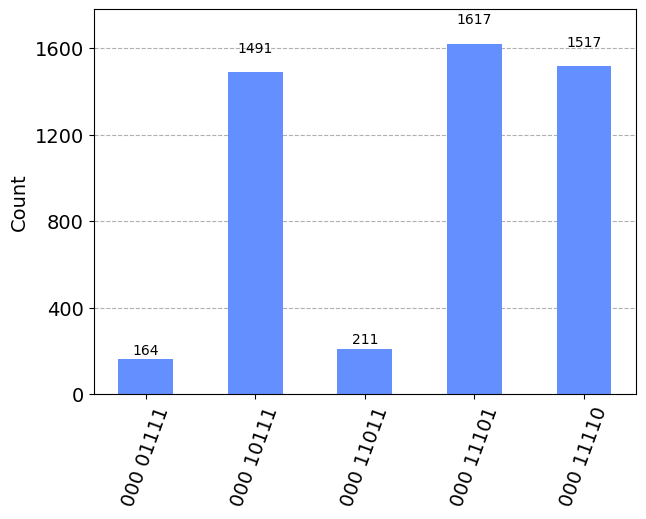

In [ ]:
# Simulate and plot results
qasm_simulator = Aer.get_backend('qasm_simulator')
#transpiled_qc = transpile(qc, qasm_simulator)
# Execute circuit and show results
ex = execute(qc, qasm_simulator, shots = 5000)
res = ex.result().get_counts(qc)
plot_histogram(res)